## explore the dataset

### settelment vaerdi from 15 min to hour

In [3]:
import pandas as pd

df = pd.read_parquet("../energinet/settlement/2019.parquet")

# 预处理
df["GSRN"] = df["GSRN"].astype(str)
df["timestamp"] = pd.to_datetime(df["TIME_CET"])

# 统一时间精度到整小时
df["timestamp"] = df["timestamp"].dt.floor("h")

# 聚合（每小时总发电量）
df_hourly = (
    df.groupby(["GSRN", "timestamp"])["VAERDI"]
    .sum()
    .reset_index()
    .rename(columns={"VAERDI": "power_output"})
)

### mapping 400 turbines' gsrn to grid

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# ---------- Step 1: 加载选择的风机 ----------
selected = pd.read_csv("../auto_split/400 turbines/selected turbines/selected_400_turbines_filtered.csv")
selected["GSRN"] = selected["GSRN"].astype(str)
selected_gsrns = selected["GSRN"].tolist()

# ---------- Step 2: 加载主数据并过滤 ----------
master = pd.read_parquet("../energinet/masterdatawind.parquet")
master["GSRN"] = master["GSRN"].astype(str)
turbines = master[master["GSRN"].isin(selected_gsrns)].copy()

# filter out ones with invalid coordinates and drop duplicates
turbines = turbines.dropna(subset=["UTM_x", "UTM_y"])
turbines = turbines.drop_duplicates(subset="GSRN", keep="first")

# 检查坐标缺失
missing_coords = turbines[["UTM_x", "UTM_y"]].isna().any(axis=1)
if missing_coords.any():
    print("the following turbines are missing coordinates and will be excluded:")
    print(turbines[missing_coords]["GSRN"].tolist())
    turbines = turbines[~missing_coords].copy()

# ---------- Step 3: 加载 grid 坐标 ----------
grid = pd.read_csv("../energinet/prognosis/grid_coordinates.csv")
grid.columns = ["grid", "utm_x", "utm_y"]

# ---------- Step 4: 匹配最近 grid ----------
turbine_coords = turbines[["UTM_x", "UTM_y"]].values
grid_coords = grid[["utm_x", "utm_y"]].values
dist_matrix = cdist(turbine_coords, grid_coords, metric="euclidean")

nearest_indices = dist_matrix.argmin(axis=1)
nearest_grids = grid.iloc[nearest_indices]["grid"].values
nearest_dists = dist_matrix.min(axis=1)

# ---------- Step 5: 保存映射 ----------
turbines["grid"] = nearest_grids
turbines["grid_distance"] = nearest_dists
turbines[["GSRN", "grid", "grid_distance"]].to_csv("gsrn_grid_mapping.csv", index=False)

print("mapping successfully, saved as gsrn_grid_mapping.csv")

mapping successfully, saved as gsrn_grid_mapping.csv


## Time-Series Features (t-2 to t) for 400 Wind Turbines in 2019

In [4]:
import pandas as pd
import numpy as np
import ast

# -------------------- Step 1: 加载风机列表 --------------------
selected = pd.read_csv("../auto_split/400 turbines/selected turbines/selected_400_turbines_filtered.csv")
selected["GSRN"] = selected["GSRN"].astype(str)
selected_gsrns = selected["GSRN"].tolist()

# -------------------- Step 2: GSRN ↔ grid 映射 --------------------
grid_map = pd.read_csv("gsrn_grid_mapping.csv")
grid_map["GSRN"] = grid_map["GSRN"].astype(str)
grid_map = grid_map.drop_duplicates(subset="GSRN")
grid_map = grid_map[grid_map["GSRN"].isin(selected_gsrns)]

missing = set(selected_gsrns) - set(grid_map["GSRN"])
if missing:
    print("❗️the following GSRN are missing grid mapping:", missing)

gsrn_to_grid = dict(zip(grid_map["GSRN"], grid_map["grid"]))

# ---------- 读取风机聚类信息 ----------
# 读取 cluster 映射数据
cluster_raw = pd.read_csv("../auto_split/400 turbines/analysis/cluster_turbine_ids.csv") 

# 展开嵌套的 GSRN 字符串列表
expanded_rows = []
for _, row in cluster_raw.iterrows():
    cluster_id = row["Cluster"]
    gsrn_list = ast.literal_eval(row["GSRN"])  # 将字符串转换为列表
    for gsrn in gsrn_list:
        expanded_rows.append({"GSRN": str(gsrn), "cluster": cluster_id})

# 构建新的 DataFrame
turbine_clusters = pd.DataFrame(expanded_rows)

# -------------------- Step 3: 加载风机元数据 --------------------
master = pd.read_parquet("../energinet/masterdatawind.parquet")
master["GSRN"] = master["GSRN"].astype(str)
master = master[master["GSRN"].isin(selected_gsrns)].copy()
master["age"] = 2019 - pd.to_datetime(master["In_service"], errors="coerce").dt.year

# -------------------- Step 4: 加载 ENetNEA 气象预报 --------------------
def extract_grid_series_with_pred(df, ahead=1):
    df = df.copy()
    df.columns = df.columns.astype(str)
    df = df[df["predicted_ahead"] == ahead]
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df.index.name = "timestamp"
    return df

wind = pd.read_parquet("../energinet/prognosis/ENetNEA/wind_speed_100m.parquet")
wind_dir = pd.read_parquet("../energinet/prognosis/ENetNEA/wind_direction_100m.parquet")
temp = pd.read_parquet("../energinet/prognosis/ENetNEA/temperatur_100m.parquet")

wind_all = extract_grid_series_with_pred(wind, ahead=1)
dir_all = extract_grid_series_with_pred(wind_dir, ahead=1)
temp_all = extract_grid_series_with_pred(temp, ahead=1)

# -------------------- Step 5: 构建每台风机的数据表 --------------------
rows = []

for gsrn in selected_gsrns:
    grid = str(gsrn_to_grid[gsrn])

    wind_series = wind_all[[grid]].rename(columns={grid: "wind_speed"})
    dir_series = dir_all[[grid]].rename(columns={grid: "wind_direction"})
    temp_series = temp_all[[grid]].rename(columns={grid: "temperature_k"})

    df = pd.concat([wind_series, dir_series, temp_series], axis=1).dropna().copy()
    df.reset_index(inplace=True)

    df = df[(df["timestamp"] >= "2019-01-01") & (df["timestamp"] < "2020-01-01")]
    df = df[df["timestamp"].dt.minute == 0]

    # 时间特征
    df["hour"] = df["timestamp"].dt.hour
    df["dow"] = df["timestamp"].dt.dayofweek
    df["month"] = df["timestamp"].dt.month
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    # 风向特征
    df["wind_dir_rad"] = np.deg2rad(df["wind_direction"])
    df["wind_dir_sin"] = np.sin(df["wind_dir_rad"])
    df["wind_dir_cos"] = np.cos(df["wind_dir_rad"])

    # 温度转换
    df["temperature_c"] = df["temperature_k"] - 273.15

    # 静态特征
    static = master[master["GSRN"] == gsrn].iloc[0]
    for col in ["Capacity_kw", "age", "UTM_x", "UTM_y"]:
        df[col] = static[col]

    # 添加 GSRN 列
    df["GSRN"] = gsrn

    # 去除该风机内重复时间
    df = df.drop_duplicates(subset="timestamp", keep="first")

    rows.append(df)

final_df = pd.concat(rows, ignore_index=True)
final_df = final_df.drop_duplicates()

# 合并发电量
final_df = final_df.merge(df_hourly, on=["GSRN", "timestamp"], how="left")

# -------------------- Step 6: 添加历史滞后特征 --------------------
# def add_history_features(df, history_window=5):
#     df = df.sort_values("timestamp").copy()
#     for i in range(1, history_window + 1):
#         df[f"wind_speed_t-{i}"] = df["wind_speed"].shift(i)
#         df[f"wind_dir_sin_t-{i}"] = df["wind_dir_sin"].shift(i)
#         df[f"wind_dir_cos_t-{i}"] = df["wind_dir_cos"].shift(i)
#         df[f"temperature_c_t-{i}"] = df["temperature_c"].shift(i)
#         df[f"power_output_t-{i}"] = df["power_output"].shift(i)
#     return df

# final_with_history = []

# for gsrn in final_df["GSRN"].unique():
#     df_one = final_df[final_df["GSRN"] == gsrn].copy()
#     df_hist = add_history_features(df_one, history_window=5)
#     final_with_history.append(df_hist)

# final_df_with_history = pd.concat(final_with_history, ignore_index=True)
# final_df_with_history = final_df_with_history.dropna().reset_index(drop=True)

# -------------------- Step 7: 只保留所需特征 --------------------
columns_to_keep = [
    "timestamp", "GSRN",
    "wind_speed", "temperature_c", "hour_sin", "hour_cos", 
    "wind_dir_sin", "wind_dir_cos", "age", "power_output",
    # "wind_speed_t-1", "wind_speed_t-2",
    # "wind_dir_sin_t-1", "wind_dir_sin_t-2",
    # "power_output_t-1", "power_output_t-2"
]

final_df_with_history = final_df_with_history[columns_to_keep]

# -------------------- Step 8: 合并 cluster 标签 --------------------
final_df_with_history = final_df_with_history.merge(
    turbine_clusters,
    on="GSRN",
    how="left"
)

# 检查是否有未匹配上的 GSRN
missing = final_df_with_history["cluster"].isna().sum()
if missing > 0:
    print(f"there are {missing} rows with missing cluster labels. please check the cluster mapping.")

# 打印检查
print("Final shape (only selected features):", final_df_with_history.shape)
print(final_df_with_history.head(10))

# -------------------- 保存 --------------------
final_df_with_history.to_csv("turbine_prediction_selected_features_400turbines.csv", index=False)

Final shape (only selected features): (1108023, 11)
            timestamp                GSRN  wind_speed  temperature_c  \
0 2019-01-01 15:00:00  571313174116253585        19.8           4.35   
1 2019-01-01 18:00:00  571313174116253585        19.3           4.75   
2 2019-01-01 21:00:00  571313174116253585        18.8           4.45   
3 2019-01-02 00:00:00  571313174116253585        21.1           3.95   
4 2019-01-02 03:00:00  571313174116253585        19.6           3.35   
5 2019-01-02 06:00:00  571313174116253585        16.9           2.15   
6 2019-01-02 09:00:00  571313174116253585        15.6           1.65   
7 2019-01-02 12:00:00  571313174116253585        16.1           1.75   
8 2019-01-02 15:00:00  571313174116253585        13.3           2.15   
9 2019-01-02 18:00:00  571313174116253585        10.1           2.65   

       hour_sin      hour_cos  wind_dir_sin  wind_dir_cos  age  \
0 -7.071068e-01 -7.071068e-01     -0.874620      0.484810    3   
1 -1.000000e+00 -1.8369

### helpful validation

In [14]:
duplicates = final_df.duplicated()
print("duplicate:", duplicates.sum())

print("count per GSRN:")
print(final_df.groupby("GSRN")["timestamp"].count())       # 总行数
print("\n")
print("unique timestamps per GSRN:")
print(final_df.groupby("GSRN")["timestamp"].nunique())     # 唯一时间戳数

duplicate: 0
count per GSRN:
GSRN
570714700000000140    2786
570714700000000157    2786
570714700000000317    2786
570714700000000324    2786
570714700000000331    2786
                      ... 
571313174001657931    2786
571313174001657962    2786
571313174001657979    2786
571313174001764448    2786
571313174116253585    2786
Name: timestamp, Length: 400, dtype: int64


unique timestamps per GSRN:
GSRN
570714700000000140    2786
570714700000000157    2786
570714700000000317    2786
570714700000000324    2786
570714700000000331    2786
                      ... 
571313174001657931    2786
571313174001657962    2786
571313174001657979    2786
571313174001764448    2786
571313174116253585    2786
Name: timestamp, Length: 400, dtype: int64


### choose two wind turbines ramdomly from 15 selected turbines

In [ ]:
!pip install seaborn
import seaborn as sns

gsrn_list = final_df_with_history["GSRN"].unique()[:2]  # 任选前两个风机
final_df_with_history["power_output"] = pd.to_numeric(final_df_with_history["power_output"], errors="coerce")


68856.22s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


## Wind Speed and Power Output for two turbines

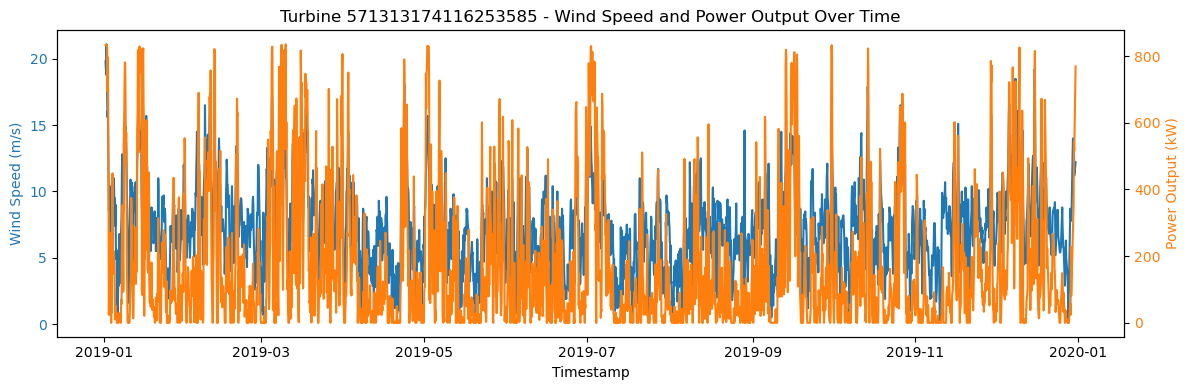

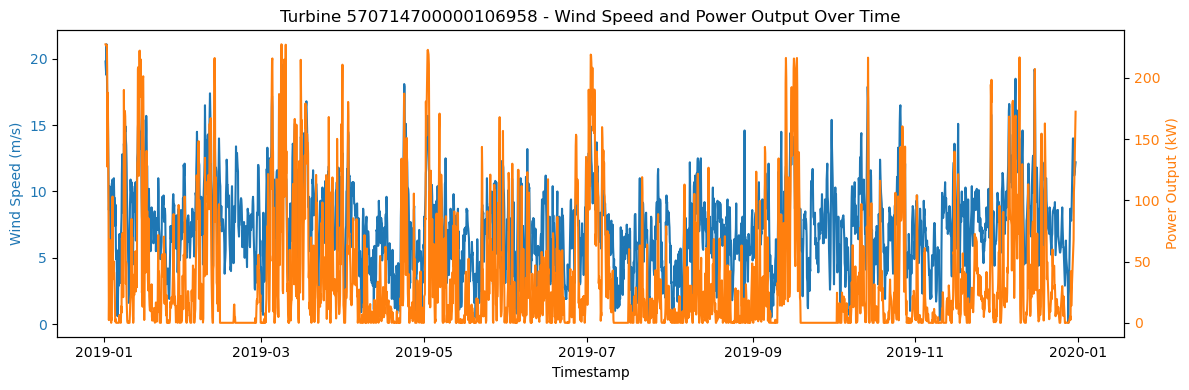

In [ ]:
import matplotlib.pyplot as plt

for gsrn in gsrn_list:
    df_turbine = final_df_with_history[final_df_with_history["GSRN"] == gsrn].sort_values("timestamp")

    fig, ax1 = plt.subplots(figsize=(12, 4))

    ax1.set_title(f"Turbine {gsrn} - Wind Speed and Power Output Over Time")
    ax1.plot(df_turbine["timestamp"], df_turbine["wind_speed"], color="tab:blue", label="Wind Speed")
    ax1.set_xlabel("Timestamp")
    ax1.set_ylabel("Wind Speed (m/s)", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    ax2 = ax1.twinx()
    ax2.plot(df_turbine["timestamp"], df_turbine["power_output"], color="tab:orange", label="Power Output")
    ax2.set_ylabel("Power Output (kW)", color="tab:orange")
    ax2.tick_params(axis="y", labelcolor="tab:orange")

    fig.tight_layout()
    plt.show()

## Temperature vs Power Output for Two Turbines

67962.47s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


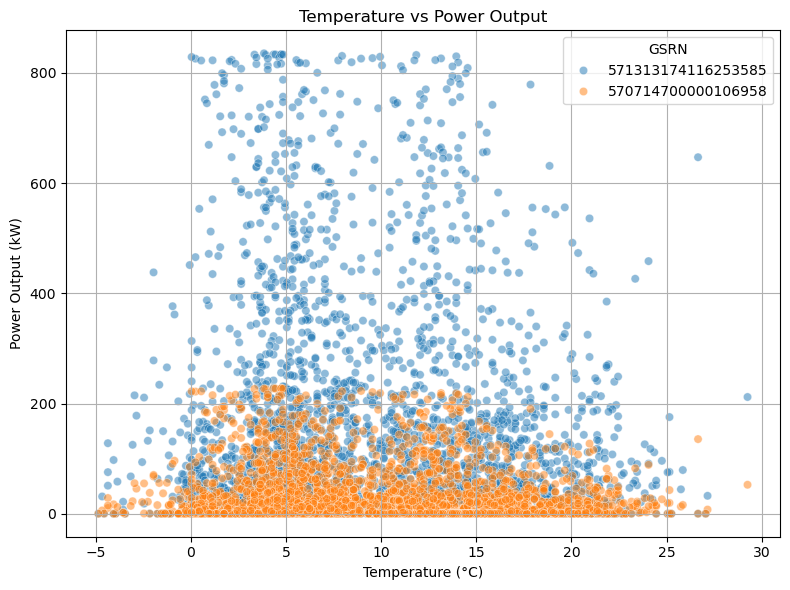

In [ ]:

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=final_df_with_history[final_df_with_history["GSRN"].isin(gsrn_list)],
    x="temperature_c", y="power_output", hue="GSRN", alpha=0.5
)
plt.xlabel("Temperature (°C)")
plt.ylabel("Power Output (kW)")
plt.title("Temperature vs Power Output")
plt.grid(True)
plt.tight_layout()
plt.show()

## Wind direction vs Power Output for Two Turbines

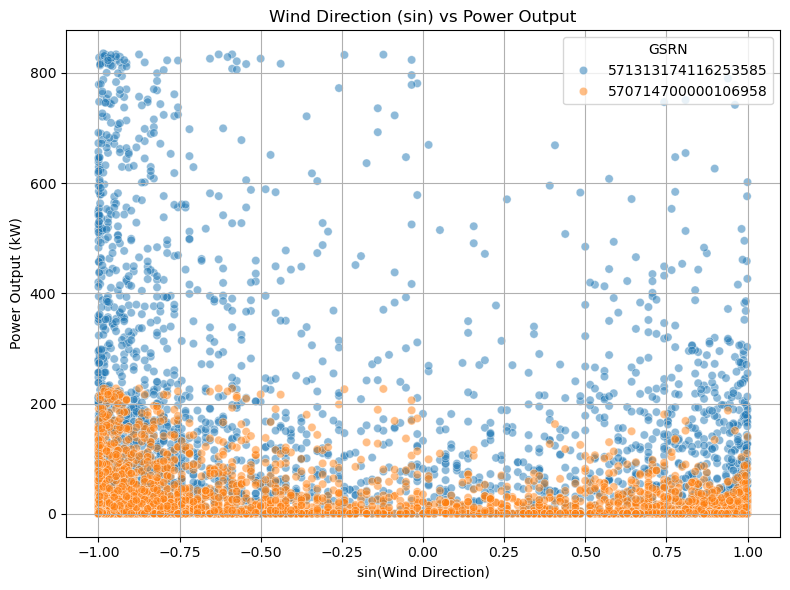

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=final_df_with_history[final_df_with_history["GSRN"].isin(gsrn_list)],
    x="wind_dir_sin", y="power_output", hue="GSRN", alpha=0.5
)
plt.xlabel("sin(Wind Direction)")
plt.ylabel("Power Output (kW)")
plt.title("Wind Direction (sin) vs Power Output")
plt.grid(True)
plt.tight_layout()
plt.show()

## Hourly Distribution of Power Output

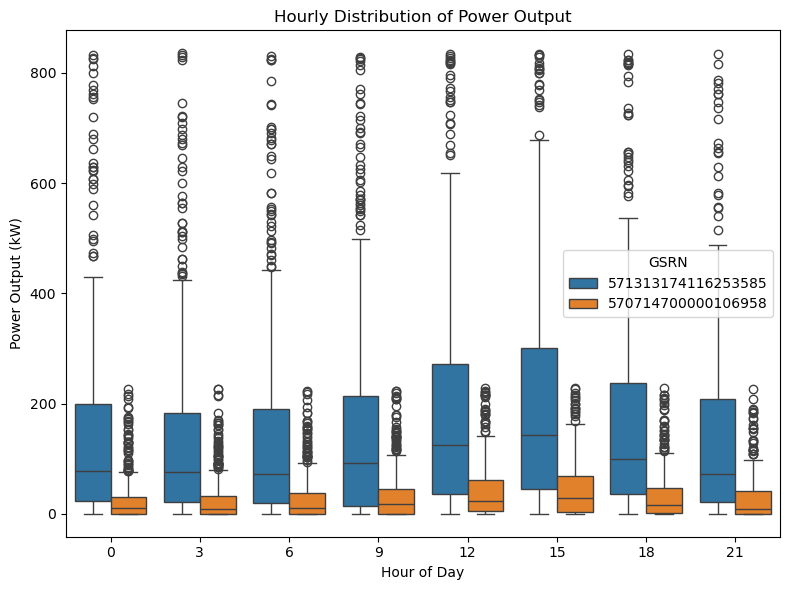

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=final_df_with_history[final_df_with_history["GSRN"].isin(gsrn_list)],
    x="hour", y="power_output", hue="GSRN"
)
plt.xlabel("Hour of Day")
plt.ylabel("Power Output (kW)")
plt.title("Hourly Distribution of Power Output")
plt.tight_layout()
plt.show()

## Current vs Historical Power Output (t vs t-5)

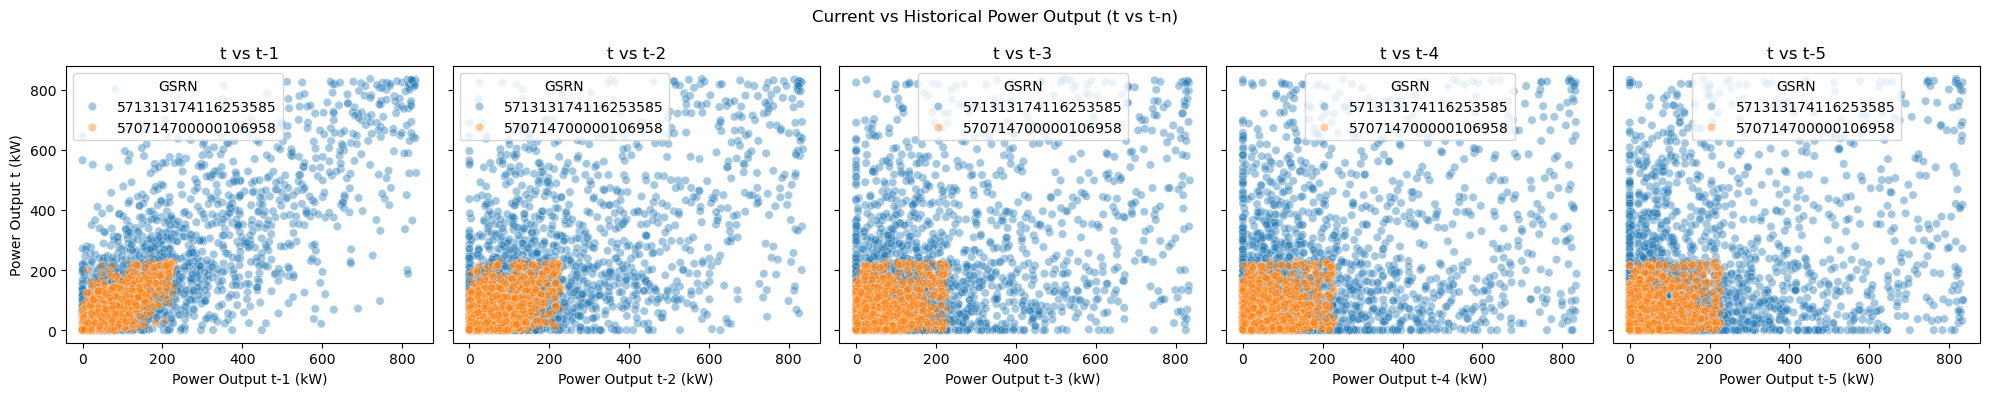

In [ ]:


# 用于绘图的数据
plot_df = final_df_with_history.copy()
plot_df["power_output"] = pd.to_numeric(plot_df["power_output"], errors="coerce")

# 添加 t-1 ~ t-5 的历史功率
for i in range(1, 6):
    plot_df[f"power_output_t-{i}"] = plot_df.groupby("GSRN")["power_output"].shift(i)

# 去除缺失值
plot_df = plot_df.dropna(subset=[f"power_output_t-{i}" for i in range(1, 6)] + ["power_output"])

# 只选两个风机
gsrn_list = plot_df["GSRN"].unique()[:2]
plot_df = plot_df[plot_df["GSRN"].isin(gsrn_list)]

# 画 5 个子图
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

for i in range(1, 6):
    ax = axes[i - 1]
    sns.scatterplot(
        data=plot_df,
        x=f"power_output_t-{i}",
        y="power_output",
        hue="GSRN",
        alpha=0.4,
        ax=ax,
       
    )
    ax.set_title(f"t vs t-{i}")
    ax.set_xlabel(f"Power Output t-{i} (kW)")
    if i == 1:
        ax.set_ylabel("Power Output t (kW)")
    else:
        ax.set_ylabel("")

plt.suptitle("Current vs Historical Power Output (t vs t-n)")
plt.tight_layout()
plt.show()

## Hourly Average Power Output (Diurnal Pattern)

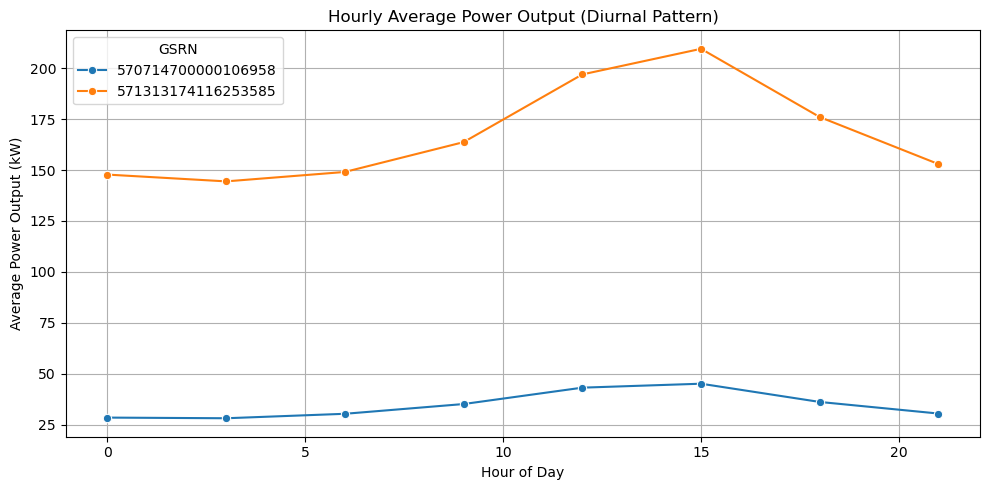

In [ ]:
# 添加小时列
df_hour_avg = final_df_with_history.copy()
df_hour_avg["hour"] = pd.to_datetime(df_hour_avg["timestamp"]).dt.hour

# 平均功率输出按小时统计
df_hour_avg = df_hour_avg[df_hour_avg["GSRN"].isin(gsrn_list)]
hourly_avg = df_hour_avg.groupby(["hour", "GSRN"])["power_output"].mean().reset_index()

# 画图
plt.figure(figsize=(10, 5))
sns.lineplot(data=hourly_avg, x="hour", y="power_output", hue="GSRN", marker="o")
plt.xlabel("Hour of Day")
plt.ylabel("Average Power Output (kW)")
plt.title("Hourly Average Power Output (Diurnal Pattern)")
plt.grid(True)
plt.tight_layout()
plt.show()